In [1]:
import pandas as pd

# Load the data for Maserati Grecale
grecale_data = pd.read_csv('/AllGrecale.csv')

# Display the first few rows of the dataset
grecale_data.head()

,Name,comments,Date
0,Mazda 3s,After months of releasing preview images and s...,"August 29, 2022"
1,Darepoole,It looks like the Macan with a little bit of I...,"March 22, 2022"
2,JackStraw79,Nice hot hatch!,"March 22, 2022"
3,CostcoPizza,"Looks like a car you'd find in GTA V DLC, whic...","March 22, 2022"
4,Venom21,Terrible gloss black: CheckTerrible touchscree...,"March 22, 2022"


In [36]:
import re

def clean_text(text):
    """Clean the text data by removing non-alphanumeric characters and converting to lowercase."""
    # Convert to string (in case of NaN values or numbers)
    text = str(text)
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    return cleaned_text

# Apply text cleaning to all datasets
grecale_data['comments'] = grecale_data['comments'].apply(clean_text)

# Display cleaned comments for Grecale as an example
grecale_data['comments'].head()

0    after months of releasing preview images and s...
1    it looks like the macan with a little bit of i...
2                                       nice hot hatch
3    looks like a car youd find in gta v dlc which ...
4    terrible gloss black checkterrible touchscreen...
Name: comments, dtype: object

In [3]:
# Convert the 'Date' column to datetime format
grecale_data['Date'] = pd.to_datetime(grecale_data['Date'], errors='coerce', infer_datetime_format=True)

# Check for any null values after conversion
null_dates = grecale_data['Date'].isnull().sum()

null_dates

0

In [21]:
# Importing necessary libraries and redefining stop words
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
!pip install transformers torch
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification,AdamW
from torch.nn.functional import softmax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.3 MB/s eta 0:00:00


In [6]:
import numpy as np

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment" # This BERT model is trained for sentiment analysis.
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [9]:
def predict_sentiments(texts, batch_size):
    sentiments = []
    model.to(device)  # Ensure model is on the correct device

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=1)
        sentiments.extend(preds.cpu().numpy())
    return sentiments

In [10]:
grecale_data['comments'] = grecale_data['comments'].astype(str)
batch_size = 32
grecale_data['sentiment'] = predict_sentiments(grecale_data['comments'].tolist(), batch_size)

In [15]:
grecale_data.to_csv('dataset_with_sentiments_grecale.csv', index=False)

In [16]:
grecale_data

,Name,comments,Date,sentiment
0,Mazda 3s,after months of releasing preview images and s...,2022-08-29,3
1,Darepoole,it looks like the macan with a little bit of i...,2022-03-22,2
2,JackStraw79,nice hot hatch,2022-03-22,3
3,CostcoPizza,looks like a car youd find in gta v dlc which ...,2022-03-22,3
4,Venom21,terrible gloss black checkterrible touchscreen...,2022-03-22,0
...,...,...,...,...
1249,urquattroGus,swoll saidso based on the poster in question i...,2022-03-28,1
1250,1974foggy,hyundai and kia make better looking suvs,2022-03-30,3
1251,ettore,this issue here is that its exceptionally dull...,2022-03-30,0
1252,CDP,truethe car isnt ugly by any means its complet...,2022-03-31,0


In [17]:
df_with_sentiments_grecale = grecale_data.copy()

In [18]:
df_with_sentiments_grecale.to_csv('dataset_with_sentiments_grecale.csv', index=False)

In [19]:
grecale_data

,Name,comments,Date,sentiment
0,Mazda 3s,after months of releasing preview images and s...,2022-08-29,3
1,Darepoole,it looks like the macan with a little bit of i...,2022-03-22,2
2,JackStraw79,nice hot hatch,2022-03-22,3
3,CostcoPizza,looks like a car youd find in gta v dlc which ...,2022-03-22,3
4,Venom21,terrible gloss black checkterrible touchscreen...,2022-03-22,0
...,...,...,...,...
1249,urquattroGus,swoll saidso based on the poster in question i...,2022-03-28,1
1250,1974foggy,hyundai and kia make better looking suvs,2022-03-30,3
1251,ettore,this issue here is that its exceptionally dull...,2022-03-30,0
1252,CDP,truethe car isnt ugly by any means its complet...,2022-03-31,0


In [20]:
# Extract comments with sentiment scores greater than 2
positive_comments = grecale_data[grecale_data['sentiment'] > 2]['comments']

# Display the first few positive comments
positive_comments.head()


0    after months of releasing preview images and s...
2                                       nice hot hatch
3    looks like a car youd find in gta v dlc which ...
6    it definitely looks like it couldve come out i...
8                              maserati grecale trofeo
Name: comments, dtype: object

In [28]:
positive_comments

0       after months of releasing preview images and s...
2                                          nice hot hatch
3       looks like a car youd find in gta v dlc which ...
6       it definitely looks like it couldve come out i...
8                                 maserati grecale trofeo
                              ...                        
1218    i like thisin black itll look mean especially ...
1227    i have seen it in the flesh and it looks nice ...
1241    the perfect car for proving beyond doubt there...
1243    i quite like it and as for looking a bit like ...
1250             hyundai and kia make better looking suvs
Name: comments, Length: 326, dtype: object

In [29]:
number_of_comments = positive_comments.shape[0]
print(number_of_comments)

326


In [26]:
import pandas as pd
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Assuming you've already loaded your dataset into 'grecale_data'
positive_comments = grecale_data[grecale_data['sentiment'] > 2]['comments']

# Preprocess the data
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stop words and specified words
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {"car", "maserati", "grecale"}
    stop_words = stop_words.union(additional_stopwords)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

tokenized_data = positive_comments.apply(preprocess)

# Create Dictionary
dictionary = corpora.Dictionary(tokenized_data)
# Create Corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic: 0 
Words: 0.011*"good" + 0.008*"great" + 0.007*"thanks" + 0.006*"like" + 0.006*"us" + 0.006*"system" + 0.005*"news" + 0.005*"assist" + 0.005*"lane" + 0.005*"looking"
Topic: 1 
Words: 0.014*"like" + 0.008*"well" + 0.006*"one" + 0.006*"looks" + 0.006*"stelvio" + 0.005*"new" + 0.005*"macan" + 0.005*"interior" + 0.005*"better" + 0.004*"really"
Topic: 2 
Words: 0.007*"level" + 0.007*"also" + 0.006*"much" + 0.006*"vehicle" + 0.005*"well" + 0.005*"assistance" + 0.005*"modena" + 0.004*"looking" + 0.004*"like" + 0.004*"without"
Topic: 3 
Words: 0.008*"suv" + 0.006*"fine" + 0.005*"trackday" + 0.005*"think" + 0.004*"like" + 0.004*"ev" + 0.004*"one" + 0.004*"works" + 0.004*"macan" + 0.004*"im"
Topic: 4 
Words: 0.008*"engine" + 0.006*"like" + 0.005*"trofeo" + 0.005*"also" + 0.005*"one" + 0.004*"alfa" + 0.004*"driving" + 0.004*"new" + 0.004*"nettuno" + 0.004*"first"


When considering extracting an audience for the Maserati Grecale, the goal is typically to identify potential buyers or enthusiasts who might be interested in the product. Based on the topics provided, the following topics seem most relevant:

1. **Topic 1 (Aesthetic and comparison):**
    - **Keywords:** like, well, looks, stelvio, macan, interior.
    - **Rationale:** This topic discusses the design and aesthetics of vehicles and also includes comparisons with other models. People discussing this topic are likely to be interested in how the Maserati Grecale looks, feels, and compares to other cars. They might be considering purchasing the Grecale or another vehicle in its class.

2. **Topic 2 (Vehicle features and performance):**
    - **Keywords:** level, vehicle, assistance, modena.
    - **Rationale:** Individuals talking about vehicle performance, features, and the brand's heritage (with the mention of "Modena") are potential enthusiasts or buyers. They're interested in the technical and performance aspects of the car, indicating deeper engagement and potential buying intent.

3. **Topic 4 (Engine and driving experience):**
    - **Keywords:** engine, trofeo, alfa, driving, nettuno.
    - **Rationale:** This topic focuses on the engine and driving experience, crucial factors for potential buyers. Discussions around the "Nettuno" engine or the driving experience can indicate individuals who are very interested in the Grecale's performance and technical specifications.

**Topic 0** is more about positive feedback and might include existing owners or general enthusiasts. While this audience is valuable for brand loyalty and advocacy, they might not be the primary target if the goal is to attract new buyers. Similarly, **Topic 3** touches upon vehicle types and general opinions, which might be broader in scope and not as specific to the Maserati Grecale's unique selling points.

In summary, for extracting a potential audience specifically for the Maserati Grecale, **Topics 1, 2, and 4** would be the most relevant.

In [27]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign a dominant topic to each comment
dominant_topics = get_dominant_topic(lda_model, corpus)

# Count the number of comments for each topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
print(topic_counts)

0    93
1    66
2    55
3    44
4    68
dtype: int64


In [30]:
# Renaming topics based on user's input
topic_names = {
    "Looks and Aesthetics": 66,
    "Vehicle Features and Performance": 55,
    "Engine and Driving Experience": 68
}

# Calculating individual percentages for each topic in relation to the entire dataset
topic_percentages = {topic: (count / number_of_comments) * 100 for topic, count in topic_names.items()}

topic_percentages

{'Looks and Aesthetics': 20.245398773006134,
 'Vehicle Features and Performance': 16.87116564417178,
 'Engine and Driving Experience': 20.858895705521473}

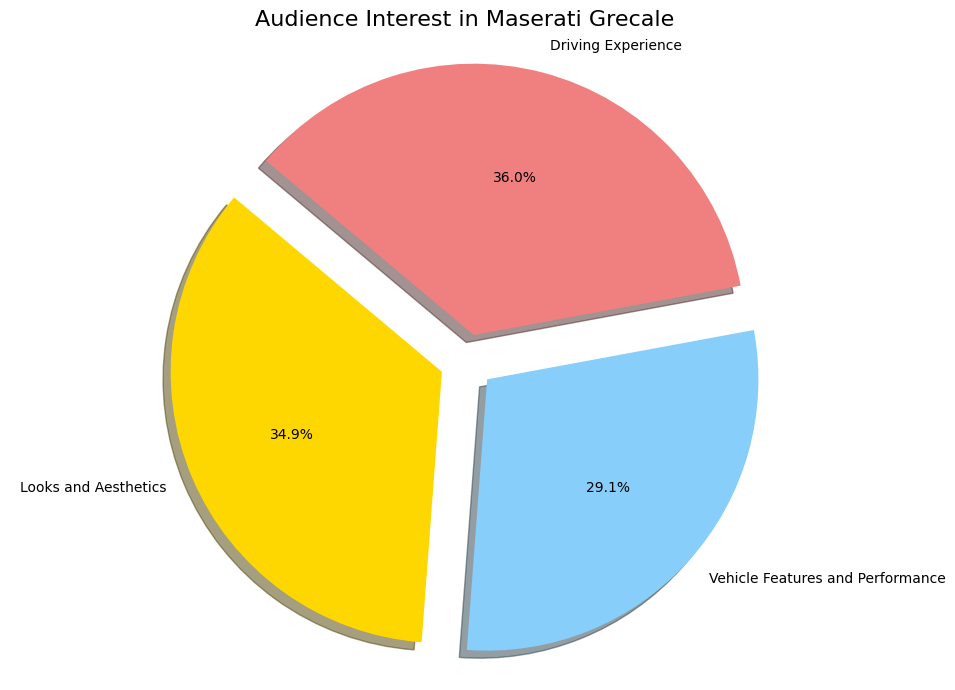

In [8]:
import matplotlib.pyplot as plt

# Corrected data provided by the user
topic_percentages_grecale = {'Looks and Aesthetics': 20.245398773006134,
 'Vehicle Features and Performance': 16.87116564417178,
 'Driving Experience': 20.858895705521473}
# Extracting data for the pie chart
labels = list(topic_percentages_grecale.keys())
sizes = list(topic_percentages_grecale.values())

# Setting explode to slightly "explode" or offset each segment
explode = (0.1, 0.1, 0.1)

# Assigning colors for each segment
colors = ['gold', 'lightskyblue', 'lightcoral']

# Plotting the pie chart again with the corrected data
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Audience Interest in Maserati Grecale', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.tight_layout()
plt.show()

In [33]:
# Load the data for Maserati Grecale
macan_data = pd.read_csv('/AllMacan.csv')

# Display the first few rows of the dataset
macan_data.head()

,Name,Comment,Date
0,oldpilot,During a regular service at my local OPC (Tonb...,"July 31, 2023"
1,Skyway,Replaced my rear wiper after just 6 months wit...,"July 31, 2023"
2,Bluesnose1812,I usually replace wipers and fill the washer f...,"July 31, 2023"
3,Skyway,Here’s my replacement process for infoviewtopi...,"July 31, 2023"
4,GWL,Part of that £68 is £50 labour.,"July 31, 2023"


In [38]:

# Apply text cleaning to all datasets
macan_data['Comment'] = macan_data['Comment'].apply(clean_text)

# Display cleaned comments for Grecale as an example
macan_data['Comment'].head()

0    during a regular service at my local opc tonbr...
1    replaced my rear wiper after just 6 months wit...
2    i usually replace wipers and fill the washer f...
3    heres my replacement process for infoviewtopic...
4                         part of that 68 is 50 labour
Name: Comment, dtype: object

In [40]:
macan_data['Comment'] = macan_data['Comment'].astype(str)
batch_size = 32
macan_data['sentiment'] = predict_sentiments(macan_data['Comment'].tolist(), batch_size)

In [41]:
macan_data.to_csv('dataset_with_sentiments_macan.csv', index=False)

In [42]:
macan_data

,Name,Comment,Date,sentiment
0,oldpilot,during a regular service at my local opc tonbr...,"July 31, 2023",0
1,Skyway,replaced my rear wiper after just 6 months wit...,"July 31, 2023",4
2,Bluesnose1812,i usually replace wipers and fill the washer f...,"July 31, 2023",3
3,Skyway,heres my replacement process for infoviewtopic...,"July 31, 2023",4
4,GWL,part of that 68 is 50 labour,"July 31, 2023",0
...,...,...,...,...
18450,Bernardino,i was loaned a nicely specced 2ltr version by ...,"March 15, 2016",3
18451,zeb,hopeydaze saidhow does it compare with an evoq...,"March 15, 2016",2
18452,bompey,i have a petrol turbo which will be 2 years ol...,"March 15, 2016",4
18453,Koln-RS,whats the typical average fuel consumption on ...,"March 15, 2016",2


In [43]:
df_with_sentiments_macan = macan_data.copy()

In [44]:
macan_data.to_csv('dataset_with_sentiments_macan.csv', index=False)

In [45]:
macan_data

,Name,Comment,Date,sentiment
0,oldpilot,during a regular service at my local opc tonbr...,"July 31, 2023",0
1,Skyway,replaced my rear wiper after just 6 months wit...,"July 31, 2023",4
2,Bluesnose1812,i usually replace wipers and fill the washer f...,"July 31, 2023",3
3,Skyway,heres my replacement process for infoviewtopic...,"July 31, 2023",4
4,GWL,part of that 68 is 50 labour,"July 31, 2023",0
...,...,...,...,...
18450,Bernardino,i was loaned a nicely specced 2ltr version by ...,"March 15, 2016",3
18451,zeb,hopeydaze saidhow does it compare with an evoq...,"March 15, 2016",2
18452,bompey,i have a petrol turbo which will be 2 years ol...,"March 15, 2016",4
18453,Koln-RS,whats the typical average fuel consumption on ...,"March 15, 2016",2


In [46]:
# Extract comments with sentiment scores greater than 2
positive_comments_macan = macan_data[macan_data['sentiment'] > 2]['Comment']

# Display the first few positive comments
positive_comments_macan.head()

1     replaced my rear wiper after just 6 months wit...
2     i usually replace wipers and fill the washer f...
3     heres my replacement process for infoviewtopic...
7          50 well its a long way to the workshop store
25    plus one i have seen one in reality and agreel...
Name: Comment, dtype: object

In [48]:



# Assuming you've already loaded your dataset into 'grecale_data'
positive_comments_macan = macan_data[macan_data['sentiment'] > 2]['Comment']

# Preprocess the data
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stop words and specified words
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {"car", "porsche", "macan"}
    stop_words = stop_words.union(additional_stopwords)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

tokenized_data = positive_comments_macan.apply(preprocess)

# Create Dictionary
dictionary = corpora.Dictionary(tokenized_data)
# Create Corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.007*"like" + 0.006*"also" + 0.005*"really" + 0.005*"black" + 0.004*"good" + 0.004*"would" + 0.004*"im" + 0.004*"well" + 0.004*"get" + 0.004*"one"
Topic: 1 
Words: 0.011*"looks" + 0.009*"great" + 0.008*"good" + 0.007*"new" + 0.006*"one" + 0.005*"get" + 0.005*"look" + 0.005*"gts" + 0.005*"nice" + 0.005*"colour"
Topic: 2 
Words: 0.009*"new" + 0.007*"thanks" + 0.007*"much" + 0.006*"would" + 0.006*"get" + 0.005*"gen" + 0.005*"cars" + 0.005*"years" + 0.005*"suspension" + 0.004*"one"
Topic: 3 
Words: 0.010*"get" + 0.009*"good" + 0.007*"like" + 0.007*"one" + 0.006*"would" + 0.006*"im" + 0.005*"gts" + 0.005*"time" + 0.005*"great" + 0.005*"miles"
Topic: 4 
Words: 0.007*"think" + 0.007*"like" + 0.006*"one" + 0.005*"great" + 0.005*"gts" + 0.005*"way" + 0.005*"got" + 0.004*"speed" + 0.004*"need" + 0.004*"time"


In [49]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign a dominant topic to each comment
dominant_topics = get_dominant_topic(lda_model, corpus)

# Count the number of comments for each topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
print(topic_counts)

0    1123
1    1339
2    1109
3    1245
4     821
dtype: int64


In [50]:
number_of_comments_macan = positive_comments_macan.shape[0]
print(number_of_comments_macan)

5637


In [55]:
# Renaming topics based on user's input
topic_names = {
    "Looks and Aesthetics": 1339,
    "New Features & Advancements": 1109,
    "Driving Experience": 1245,
    "Performance and Handling": 821,

}

# Calculating individual percentages for each topic in relation to the entire dataset
topic_percentages = {topic: (count / number_of_comments_macan) * 100 for topic, count in topic_names.items()}

topic_percentages

{'Looks and Aesthetics': 23.753769735675004,
 'New Features & Advancements': 19.673585240376088,
 'Driving Experience': 22.086216072378924,
 'Performance and Handling': 14.564484654958312}

In [4]:
x = 22.086216072378924 + 14.564484654958312

In [5]:
x

36.65070072733724

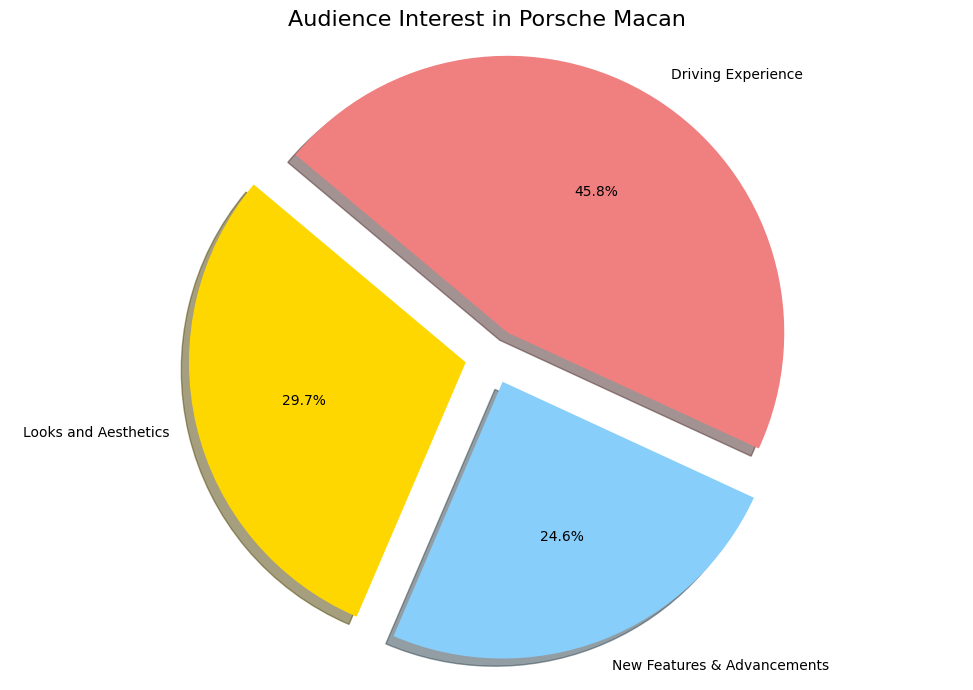

In [7]:
import matplotlib.pyplot as plt

# Corrected data provided by the user
topic_percentages_macan = {
    'Looks and Aesthetics': 23.753769735675004,
    'New Features & Advancements': 19.673585240376088,
    'Driving Experience': 36.65070072733724 ,

}

# Extracting data for the pie chart
labels = list(topic_percentages_macan.keys())
sizes = list(topic_percentages_macan.values())

# Setting explode to slightly "explode" or offset each segment
explode = (0.1, 0.1, 0.1)

# Assigning colors for each segment
colors = ['gold', 'lightskyblue', 'lightcoral', 'lightgreen']

# Plotting the pie chart with the defined explode and colors
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Audience Interest in Porsche Macan', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.tight_layout()
plt.show()

In [63]:
# Load the data for Maserati Grecale
bmw_data = pd.read_csv('/AllBMW_X3.csv')

# Display the first few rows of the dataset
bmw_data.head()

,Name,Comment,Date
0,Jon Shafer,Here you go!Now accepting custom orders for Ma...,"April 18, 2020"
1,mmlocke,Interesting standard equipment. Has it been co...,"January 16, 2020"
2,Jon Shafer,"That, I can't tell you..:dunno:","January 16, 2020"
3,Mark Levine,NaN,"February 1, 2020"
4,Mark Levine,"Sorry should read""pdf'","February 1, 2020"


In [65]:

# Apply text cleaning to all datasets
bmw_data['Comment'] = bmw_data['Comment'].apply(clean_text)

# Display cleaned comments for Grecale as an example
bmw_data['Comment'].head()

0    here you gonow accepting custom orders for mar...
1    interesting standard equipment has it been con...
2                            that i cant tell youdunno
3                                                  nan
4                                 sorry should readpdf
Name: Comment, dtype: object

In [66]:
bmw_data['Comment'] = bmw_data['Comment'].astype(str)
batch_size = 32
bmw_data['sentiment'] = predict_sentiments(bmw_data['Comment'].tolist(), batch_size)

In [67]:
bmw_data.to_csv('dataset_with_sentiments_bmw.csv', index=False)

In [68]:
bmw_data

,Name,Comment,Date,sentiment
0,Jon Shafer,here you gonow accepting custom orders for mar...,"April 18, 2020",4
1,mmlocke,interesting standard equipment has it been con...,"January 16, 2020",3
2,Jon Shafer,that i cant tell youdunno,"January 16, 2020",4
3,Mark Levine,nan,"February 1, 2020",1
4,Mark Levine,sorry should readpdf,"February 1, 2020",0
...,...,...,...,...
12262,130idvg,good deals can be negotiated on new we had the...,"May 04, 2021",3
12263,MarkGArgyle,thanks for all the advice and commentscoming b...,"May 13, 2021",3
12264,SouthSide92,markgargyle saidthanks for all the advice and ...,"December 13, 2021",0
12265,hilly10,markgargyle saidi think insurance and running ...,"December 13, 2021",1


In [69]:
df_with_sentiments_bmw = bmw_data.copy()

In [70]:
bmw_data.to_csv('dataset_with_sentiments_bmw.csv', index=False)

In [71]:
bmw_data

,Name,Comment,Date,sentiment
0,Jon Shafer,here you gonow accepting custom orders for mar...,"April 18, 2020",4
1,mmlocke,interesting standard equipment has it been con...,"January 16, 2020",3
2,Jon Shafer,that i cant tell youdunno,"January 16, 2020",4
3,Mark Levine,nan,"February 1, 2020",1
4,Mark Levine,sorry should readpdf,"February 1, 2020",0
...,...,...,...,...
12262,130idvg,good deals can be negotiated on new we had the...,"May 04, 2021",3
12263,MarkGArgyle,thanks for all the advice and commentscoming b...,"May 13, 2021",3
12264,SouthSide92,markgargyle saidthanks for all the advice and ...,"December 13, 2021",0
12265,hilly10,markgargyle saidi think insurance and running ...,"December 13, 2021",1


In [72]:
# Extract comments with sentiment scores greater than 2
positive_comments_bmw = bmw_data[bmw_data['sentiment'] > 2]['Comment']

# Display the first few positive comments
positive_comments_bmw.head()

0    here you gonow accepting custom orders for mar...
1    interesting standard equipment has it been con...
2                            that i cant tell youdunno
7    all electric range epa estimateshi jonwhat is ...
8    looks like they are showing up on dealer lots ...
Name: Comment, dtype: object

In [73]:
# Assuming you've already loaded your dataset into 'grecale_data'
positive_comments_bmw = bmw_data[bmw_data['sentiment'] > 2]['Comment']

# Preprocess the data
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stop words and specified words
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {"car", "bmw", "x3"}
    stop_words = stop_words.union(additional_stopwords)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

tokenized_data = positive_comments_bmw.apply(preprocess)

# Create Dictionary
dictionary = corpora.Dictionary(tokenized_data)
# Create Corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"thanks" + 0.008*"get" + 0.008*"like" + 0.006*"package" + 0.006*"good" + 0.005*"app" + 0.004*"dealer" + 0.004*"got" + 0.004*"great" + 0.004*"mobile"
Topic: 1 
Words: 0.007*"like" + 0.007*"using" + 0.006*"sport" + 0.006*"great" + 0.005*"im" + 0.005*"iphone" + 0.005*"color" + 0.005*"seats" + 0.005*"adaptive" + 0.005*"get"
Topic: 2 
Words: 0.016*"tires" + 0.009*"wheels" + 0.009*"tire" + 0.007*"would" + 0.007*"winter" + 0.006*"wheel" + 0.006*"set" + 0.006*"sport" + 0.005*"ride" + 0.005*"one"
Topic: 3 
Words: 0.008*"would" + 0.007*"one" + 0.006*"also" + 0.006*"like" + 0.006*"new" + 0.005*"better" + 0.005*"much" + 0.005*"love" + 0.005*"thanks" + 0.005*"nice"
Topic: 4 
Words: 0.011*"new" + 0.009*"get" + 0.008*"like" + 0.007*"one" + 0.006*"well" + 0.005*"good" + 0.005*"know" + 0.005*"think" + 0.005*"would" + 0.004*"great"


In [74]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign a dominant topic to each comment
dominant_topics = get_dominant_topic(lda_model, corpus)

# Count the number of comments for each topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
print(topic_counts)

0    920
1    771
2    524
3    735
4    923
dtype: int64


In [75]:
number_of_comments_bmw = positive_comments_bmw.shape[0]
print(number_of_comments_bmw)

3873


In [77]:
# Renaming topics based on user's input
topic_names = {
    "Purchase Experience & Mobie App": 920,
    "Features & Technological Compatability": 771,
    "Tyres & Ride Quality": 524,

}

# Calculating individual percentages for each topic in relation to the entire dataset
topic_percentages = {topic: (count / number_of_comments_bmw) * 100 for topic, count in topic_names.items()}

topic_percentages

{'Purchase Experience & Mobie App': 23.754195713916857,
 'Features & Technological Compatability': 19.907048799380327,
 'Tyres & Ride Quality': 13.529563645752646}

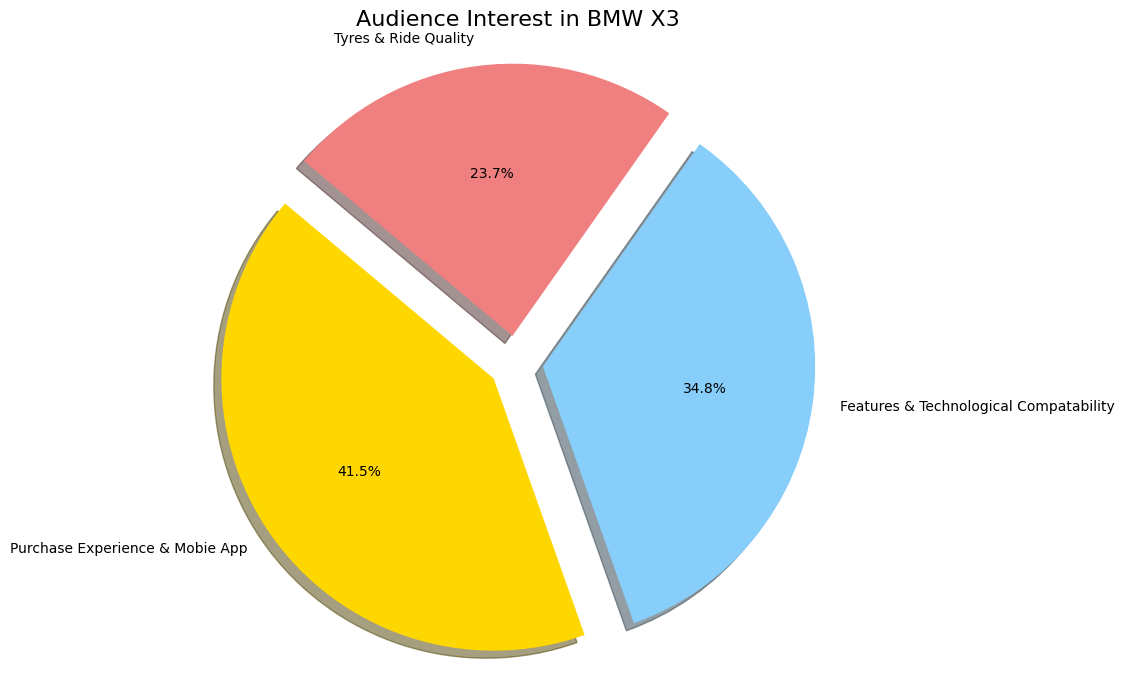

In [79]:
import matplotlib.pyplot as plt

# Corrected data provided by the user
topic_percentages_bmw = {'Purchase Experience & Mobie App': 23.754195713916857,
 'Features & Technological Compatability': 19.907048799380327,
 'Tyres & Ride Quality': 13.529563645752646

}

# Extracting data for the pie chart
labels = list(topic_percentages_bmw.keys())
sizes = list(topic_percentages_bmw.values())

# Setting explode to slightly "explode" or offset each segment
explode = (0.1, 0.1, 0.1)

# Assigning colors for each segment
colors = ['gold', 'lightskyblue', 'lightcoral']

# Plotting the pie chart with the defined explode and colors
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Audience Interest in BMW X3', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.tight_layout()
plt.show()

In [80]:
# Load the data for Maserati Grecale
audi_data = pd.read_csv('/AllAudi_Q5.csv')

# Display the first few rows of the dataset
audi_data.head()

,Name,Comment,Date
0,rapidcool,"Not rules, just some thoughts for your conside...","October 4, 2014"
1,Chopper,I knew it was too good to be true!,"October 10, 2013"
2,rapidcool,"Those who find it difficult to post pictures, ...","October 17, 2013"
3,beafraid,The links to his images are to an external sit...,"October 4, 2014"
4,Rahoo,Kaine - gone but never forgotten...,"August 26, 2011"


In [81]:
# Apply text cleaning to all datasets
audi_data['Comment'] = audi_data['Comment'].apply(clean_text)

# Display cleaned comments for Grecale as an example
audi_data['Comment'].head()

0    not rules just some thoughts for your consider...
1                    i knew it was too good to be true
2    those who find it difficult to post pictures m...
3    the links to his images are to an external sit...
4                      kaine  gone but never forgotten
Name: Comment, dtype: object

In [82]:
audi_data['Comment'] = audi_data['Comment'].astype(str)
batch_size = 32
audi_data['sentiment'] = predict_sentiments(audi_data['Comment'].tolist(), batch_size)

In [83]:
audi_data.to_csv('dataset_with_sentiments_audi.csv', index=False)

In [84]:
audi_data

,Name,Comment,Date,sentiment
0,rapidcool,not rules just some thoughts for your consider...,"October 4, 2014",0
1,Chopper,i knew it was too good to be true,"October 10, 2013",1
2,rapidcool,those who find it difficult to post pictures m...,"October 17, 2013",2
3,beafraid,the links to his images are to an external sit...,"October 4, 2014",0
4,Rahoo,kaine gone but never forgotten,"August 26, 2011",3
...,...,...,...,...
10048,900sAds,looks like the 32 gets the most votes then tha...,"January 26, 2021",0
10049,Hfs1889,i have a 2019 q5 quattro with the 45 tfsi 245 ...,"January 26, 2021",2
10050,Pistonheader101,20t is actually a great engine and suits the q...,"January 26, 2021",3
10051,ZX10R NIN,hfs1889 saidi have a 2019 q5 quattro with the ...,"January 27, 2021",2


In [85]:
df_with_sentiments_audi = audi_data.copy()

In [86]:
audi_data.to_csv('dataset_with_sentiments_audi.csv', index=False)

In [87]:
audi_data

,Name,Comment,Date,sentiment
0,rapidcool,not rules just some thoughts for your consider...,"October 4, 2014",0
1,Chopper,i knew it was too good to be true,"October 10, 2013",1
2,rapidcool,those who find it difficult to post pictures m...,"October 17, 2013",2
3,beafraid,the links to his images are to an external sit...,"October 4, 2014",0
4,Rahoo,kaine gone but never forgotten,"August 26, 2011",3
...,...,...,...,...
10048,900sAds,looks like the 32 gets the most votes then tha...,"January 26, 2021",0
10049,Hfs1889,i have a 2019 q5 quattro with the 45 tfsi 245 ...,"January 26, 2021",2
10050,Pistonheader101,20t is actually a great engine and suits the q...,"January 26, 2021",3
10051,ZX10R NIN,hfs1889 saidi have a 2019 q5 quattro with the ...,"January 27, 2021",2


In [88]:
# Extract comments with sentiment scores greater than 2
positive_comments_audi = audi_data[macan_data['sentiment'] > 2]['Comment']

# Display the first few positive comments
positive_comments_audi.head()

<ipython-input-88-692fbd07fdec>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_comments_audi = audi_data[macan_data['sentiment'] > 2]['Comment']


1                     i knew it was too good to be true
2     those who find it difficult to post pictures m...
3     the links to his images are to an external sit...
7     one thing i agree with trump we are rapidly be...
25       excellent news that your order is progressing 
Name: Comment, dtype: object

In [89]:
# Assuming you've already loaded your dataset into 'grecale_data'
positive_comments_audi = audi_data[macan_data['sentiment'] > 2]['Comment']

# Preprocess the data
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stop words and specified words
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {"car", "audi", "q5"}
    stop_words = stop_words.union(additional_stopwords)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

tokenized_data = positive_comments_audi.apply(preprocess)

# Create Dictionary
dictionary = corpora.Dictionary(tokenized_data)
# Create Corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

<ipython-input-89-09378370c0a2>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_comments_audi = audi_data[macan_data['sentiment'] > 2]['Comment']


Topic: 0 
Words: 0.009*"one" + 0.007*"would" + 0.006*"dealer" + 0.006*"order" + 0.005*"like" + 0.005*"black" + 0.005*"blue" + 0.005*"get" + 0.004*"plus" + 0.004*"new"
Topic: 1 
Words: 0.012*"would" + 0.010*"new" + 0.008*"dont" + 0.007*"think" + 0.006*"like" + 0.005*"years" + 0.005*"good" + 0.005*"year" + 0.005*"tyres" + 0.004*"around"
Topic: 2 
Words: 0.009*"new" + 0.008*"get" + 0.006*"good" + 0.006*"miles" + 0.006*"much" + 0.005*"im" + 0.005*"also" + 0.005*"one" + 0.005*"think" + 0.005*"last"
Topic: 3 
Words: 0.007*"new" + 0.006*"would" + 0.006*"dealer" + 0.006*"cars" + 0.006*"get" + 0.005*"uk" + 0.005*"still" + 0.004*"one" + 0.004*"done" + 0.004*"got"
Topic: 4 
Words: 0.007*"like" + 0.007*"get" + 0.006*"would" + 0.005*"new" + 0.005*"im" + 0.005*"really" + 0.005*"ive" + 0.005*"back" + 0.004*"got" + 0.004*"one"


In [90]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

In [91]:
# Assign a dominant topic to each comment
dominant_topics = get_dominant_topic(lda_model, corpus)

# Count the number of comments for each topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
print(topic_counts)

0    648
1    604
2    554
3    665
4    620
dtype: int64


In [92]:
number_of_comments_audi = positive_comments_audi.shape[0]
print(number_of_comments_audi)

3091


In [93]:
# Renaming topics based on user's input
topic_names = {
    "Colour Preferences": 648,
    "Durability": 604,
    "Performance and mileage": 554,
    "Dealership Experience": 665,

}

# Calculating individual percentages for each topic in relation to the entire dataset
topic_percentages = {topic: (count / number_of_comments_audi) * 100 for topic, count in topic_names.items()}

topic_percentages

{'Colour Preferences': 20.964089291491426,
 'Durability': 19.54060174700744,
 'Performance and mileage': 17.923002264639276,
 'Dealership Experience': 21.514073115496604}

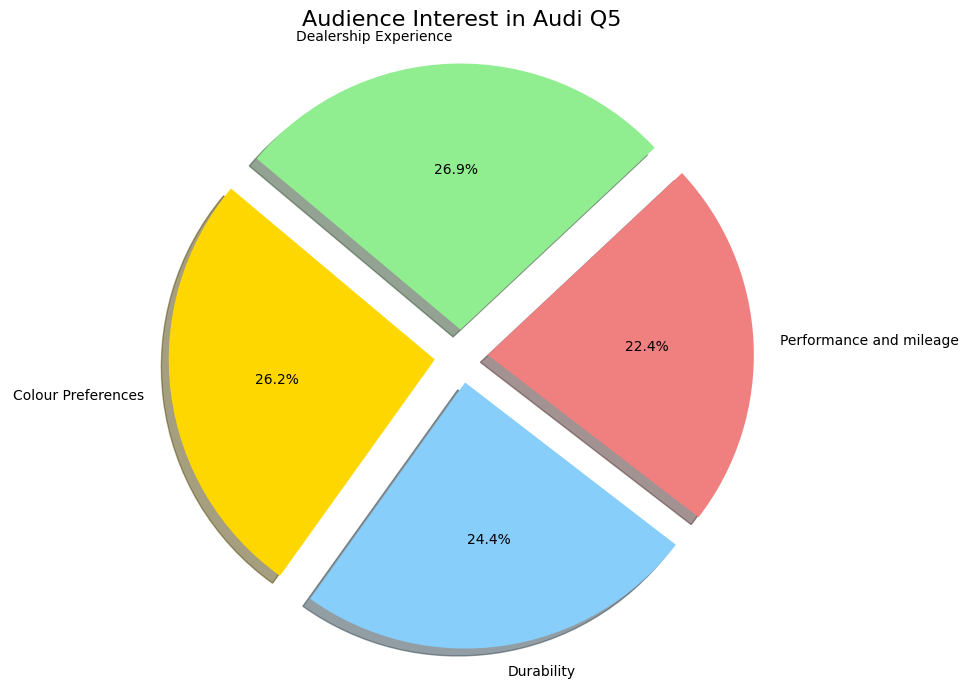

In [95]:
import matplotlib.pyplot as plt

# Corrected data provided by the user
topic_percentages_audi = { 'Colour Preferences': 20.964089291491426,
 'Durability': 19.54060174700744,
 'Performance and mileage': 17.923002264639276,
 'Dealership Experience': 21.514073115496604

}

# Extracting data for the pie chart
labels = list(topic_percentages_audi.keys())
sizes = list(topic_percentages_audi.values())

# Setting explode to slightly "explode" or offset each segment
explode = (0.1, 0.1, 0.1, 0.1)

# Assigning colors for each segment
colors = ['gold', 'lightskyblue', 'lightcoral', 'lightgreen']

# Plotting the pie chart with the defined explode and colors
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Audience Interest in Audi Q5', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.tight_layout()
plt.show()

In [96]:
# Load the data for Maserati Grecale
stelvio_data = pd.read_csv('/AllStelvio.csv')

# Display the first few rows of the dataset
stelvio_data.head()

,Name,Comment,Date
0,cue2,Saw three Stelvia in a couple of days in Spain...,"July 24, 2023"
1,dcjarvis,They had a couple of them at the dealers yeste...,"September 2, 2017"
2,cue2,Car Magazine tested it and it becomes clear wh...,"September 2, 2017"
3,PapaSmurf,The official launch is next Saturday but there...,"September 2, 2017"
4,JTD_Liam,"Ahh right, I'll cut Alfa a bit of slack for no...","September 2, 2017"


In [97]:
# Apply text cleaning to all datasets
stelvio_data['Comment'] = stelvio_data['Comment'].apply(clean_text)

# Display cleaned comments for Grecale as an example
stelvio_data['Comment'].head()

0    saw three stelvia in a couple of days in spain...
1    they had a couple of them at the dealers yeste...
2    car magazine tested it and it becomes clear wh...
3    the official launch is next saturday but there...
4    ahh right ill cut alfa a bit of slack for now ...
Name: Comment, dtype: object

In [98]:
stelvio_data['Comment'] = stelvio_data['Comment'].astype(str)
batch_size = 32
stelvio_data['sentiment'] = predict_sentiments(stelvio_data['Comment'].tolist(), batch_size)

In [99]:
stelvio_data.to_csv('dataset_with_sentiments_stelvio.csv', index=False)

In [100]:
stelvio_data

,Name,Comment,Date,sentiment
0,cue2,saw three stelvia in a couple of days in spain...,"July 24, 2023",2
1,dcjarvis,they had a couple of them at the dealers yeste...,"September 2, 2017",2
2,cue2,car magazine tested it and it becomes clear wh...,"September 2, 2017",3
3,PapaSmurf,the official launch is next saturday but there...,"September 2, 2017",2
4,JTD_Liam,ahh right ill cut alfa a bit of slack for now ...,"September 2, 2017",1
...,...,...,...,...
8738,BikeSausage,if i were in the market for an suv dont expect...,"May 15, 2023",1
8739,QuattroDave,quattrodave saidronniehotdogs saidkambites sai...,"May 15, 2023",2
8740,QuattroDave,bikesausage saidif i were in the market for an...,"May 15, 2023",2
8741,BikeSausage,quattrodave saidbikesausage saidif i were in t...,"May 16, 2023",2


In [101]:
df_with_sentiments_stelvio = stelvio_data.copy()

In [102]:
stelvio_data.to_csv('dataset_with_sentiments_stelvio.csv', index=False)

In [103]:
stelvio_data

,Name,Comment,Date,sentiment
0,cue2,saw three stelvia in a couple of days in spain...,"July 24, 2023",2
1,dcjarvis,they had a couple of them at the dealers yeste...,"September 2, 2017",2
2,cue2,car magazine tested it and it becomes clear wh...,"September 2, 2017",3
3,PapaSmurf,the official launch is next saturday but there...,"September 2, 2017",2
4,JTD_Liam,ahh right ill cut alfa a bit of slack for now ...,"September 2, 2017",1
...,...,...,...,...
8738,BikeSausage,if i were in the market for an suv dont expect...,"May 15, 2023",1
8739,QuattroDave,quattrodave saidronniehotdogs saidkambites sai...,"May 15, 2023",2
8740,QuattroDave,bikesausage saidif i were in the market for an...,"May 15, 2023",2
8741,BikeSausage,quattrodave saidbikesausage saidif i were in t...,"May 16, 2023",2


In [105]:
# Extract comments with sentiment scores greater than 2
positive_comments_stelvio = stelvio_data[stelvio_data['sentiment'] > 2]['Comment']

# Display the first few positive comments
positive_comments_stelvio.head()

2     car magazine tested it and it becomes clear wh...
6     alfa build batches of cars to get stocks up fo...
11                           i admire your optimism lol
17      alfa romeo need to do cars like this to survive
23    saw one in lisbon and was pleasantly surprised...
Name: Comment, dtype: object

In [106]:
# Assuming you've already loaded your dataset into 'grecale_data'
positive_comments_stelvio = stelvio_data[stelvio_data['sentiment'] > 2]['Comment']

# Preprocess the data
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stop words and specified words
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {"car", "alfa", "romeo" , "stelvio"}
    stop_words = stop_words.union(additional_stopwords)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

tokenized_data = positive_comments_stelvio.apply(preprocess)

# Create Dictionary
dictionary = corpora.Dictionary(tokenized_data)
# Create Corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"one" + 0.008*"thanks" + 0.006*"blue" + 0.005*"giulia" + 0.005*"need" + 0.004*"get" + 0.004*"dont" + 0.004*"dealer" + 0.004*"good" + 0.004*"know"
Topic: 1 
Words: 0.008*"like" + 0.008*"suv" + 0.007*"forum" + 0.006*"make" + 0.005*"stelvioforumcom" + 0.005*"largest" + 0.005*"new" + 0.005*"looks" + 0.005*"one" + 0.005*"im"
Topic: 2 
Words: 0.007*"good" + 0.006*"like" + 0.006*"new" + 0.005*"one" + 0.005*"well" + 0.005*"giulia" + 0.005*"first" + 0.004*"see" + 0.004*"years" + 0.004*"ive"
Topic: 3 
Words: 0.008*"good" + 0.006*"using" + 0.005*"one" + 0.005*"around" + 0.005*"nice" + 0.005*"like" + 0.005*"well" + 0.005*"giulia" + 0.005*"still" + 0.004*"back"
Topic: 4 
Words: 0.007*"giulia" + 0.007*"new" + 0.007*"get" + 0.006*"would" + 0.006*"good" + 0.005*"one" + 0.005*"like" + 0.005*"great" + 0.005*"also" + 0.004*"time"


In [107]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign a dominant topic to each comment
dominant_topics = get_dominant_topic(lda_model, corpus)

# Count the number of comments for each topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
print(topic_counts)

0    516
1    424
2    449
3    586
4    587
dtype: int64


In [108]:
number_of_comments_stelvio = positive_comments_stelvio.shape[0]
print(number_of_comments_stelvio)

2562


In [109]:
# Renaming topics based on user's input
topic_names = {
    "Looks and Aesthetics": 424,
    "Driving Experience": 586,


}

# Calculating individual percentages for each topic in relation to the entire dataset
topic_percentages = {topic: (count / number_of_comments_stelvio) * 100 for topic, count in topic_names.items()}

topic_percentages

{'Looks and Aesthetics': 16.549570647931304,
 'Driving Experience': 22.872755659640905}

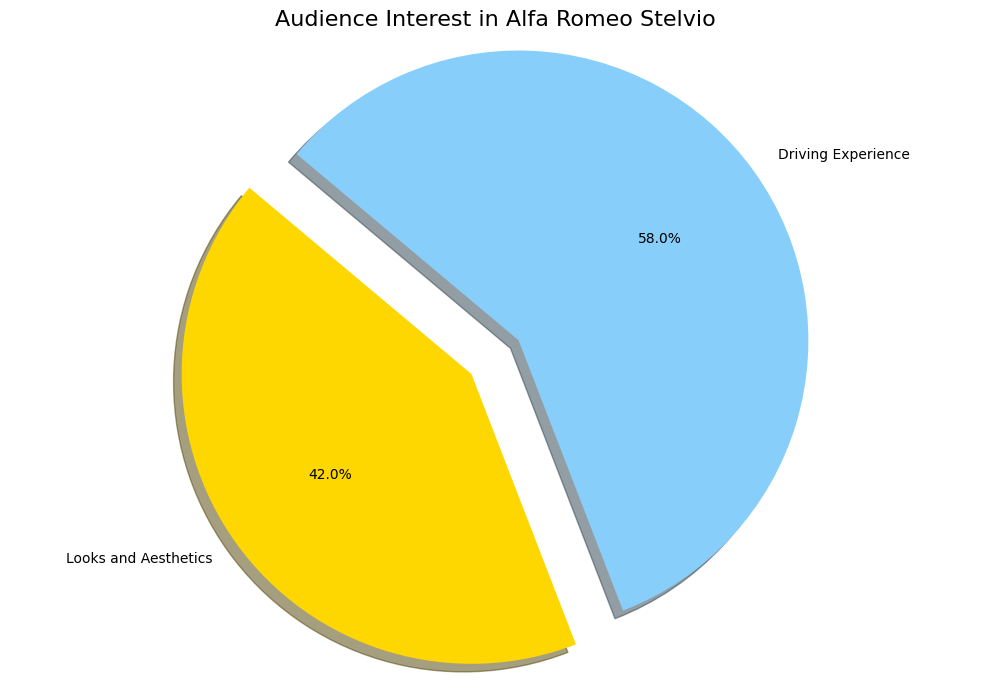

In [111]:
import matplotlib.pyplot as plt

# Corrected data provided by the user
topic_percentages_stelvio = { 'Looks and Aesthetics': 16.549570647931304,
 'Driving Experience': 22.872755659640905
   }

# Extracting data for the pie chart
labels = list(topic_percentages_stelvio.keys())
sizes = list(topic_percentages_stelvio.values())

# Setting explode to slightly "explode" or offset each segment
explode = (0.1, 0.1)

# Assigning colors for each segment
colors = ['gold', 'lightskyblue']

# Plotting the pie chart with the defined explode and colors
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Audience Interest in Alfa Romeo Stelvio', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.tight_layout()
plt.show()